In [1]:
from phoenix import distributionfunction, sampling, actions_to_phase_space
from phoenix.potentials import miyamoto_nagai_potential, plummer_potential
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

/Users/annalena/Documents/GitHub/phoenix/phoenix/distributionfunctions_disky_Binney.py:10: UserWarning: As of jaxtyping version 0.2.24, jaxtyping now prefers the syntax
```
from jaxtyping import jaxtyped
# Use your favourite typechecker: usually one of the two lines below.
from typeguard import typechecked as typechecker
from beartype import beartype as typechecker

@jaxtyped(typechecker=typechecker)
def foo(...):
```
and the old double-decorator syntax
```
@jaxtyped
@typechecker
def foo(...):
```
should no longer be used. (It will continue to work as it did before, but the new approach will produce more readable error messages.)
In particular note that `typechecker` must be passed via keyword argument; the following is not valid:
```
@jaxtyped(typechecker)
def foo(...):
```

  @jaxtyped
/Users/annalena/Documents/GitHub/phoenix/phoenix/distributionfunctions_disky_Binney.py:38: UserWarning: As of jaxtyping version 0.2.24, jaxtyping now prefers the syntax
```
from jaxtyping import jaxtyp

In [2]:
params = {
    "R0": 8.0, # for actions to phase space
    "Rinit": 8.0, # for sampling
    "R0_thin": 5.0,
    "Rd_thin": 2.5,
    "Sigma0_thin": 50.0,
    "RsigR_thin": 8.0,
    "RsigZ_thin": 2.0,
    "sigmaR0_R0_thin": 40.0,
    "sigmaz0_R0_thin": 25.0,
    "L0_thin": 50.0,
    "Rinit_for_Rc_thin": 8.0,
    "R0_thick": 8.0,
    "Rd_thick": 2.0,
    "Sigma0_thick": 150.0,
    "RsigR_thick": 8.0,
    "RsigZ_thick": 4.0,
    "sigmaR0_R0_thick": 60.0,
    "sigmaz0_R0_thick": 40.0,
    "L0_thick": 50.0,
    "Rinit_for_Rc_thick": 8.0,
    "f_thin": 0.0,
    "f_thick": 0.0,
    "f_spheroid": 1.0,
    "N0_spheroid": 1e5,
    "J0_spheroid": 100.0,
    "Gamma_spheroid": 1.5,
    "Beta_spheroid": 4.5,
}

In [3]:
envelope_max = 3.0
n_candidates = 500_000
key = jax.random.PRNGKey(42)

In [4]:
Phi_thin = miyamoto_nagai_potential
Phi_thick = miyamoto_nagai_potential
Phi_spheroid = plummer_potential
Phi_halo = plummer_potential

theta_thin = jnp.array([1e12, 10.0, 200.0]) # (M, a, b) z.B. für Miyamoto–Nagai
theta_thick = jnp.array([1e12, 15.0, 25.0]) # (M, a, b) z.B. für Miyamoto–Nagai
theta_spheroid = jnp.array([1e12, 10.0]) # (M, a) z.B. für Plummer
theta_halo = jnp.array([1e12, 100.0]) # (M, a) z.B. für Plummer

In [5]:
#Generate candidate actions
candidates, samples, soft_weights = sampling.sample_df_potential(key, params, Phi_thin, Phi_thick, Phi_spheroid, theta_thin, theta_thick, theta_spheroid, n_candidates, envelope_max, tau=0.01)
print("Number of candidate actions:", samples.shape[0])

Number of candidate actions: 500000


In [6]:
jnp.sum(soft_weights)

Array(3450.7158, dtype=float32)

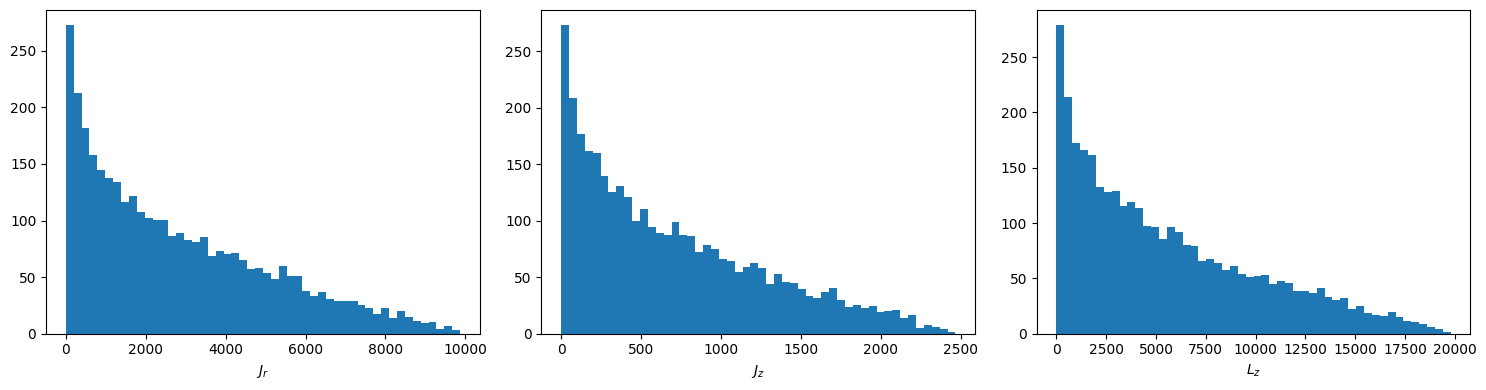

In [7]:
#Visualize the distribution of candidate actions
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].hist(samples[:, 0], bins=50, weights=soft_weights)
axs[0].set_xlabel(r"$J_r$")
axs[1].hist(samples[:, 1], bins=50, weights=soft_weights)
axs[1].set_xlabel(r"$J_z$")
axs[2].hist(samples[:, 2], bins=50, weights=soft_weights)
axs[2].set_xlabel(r"$L_z$")
plt.tight_layout()
plt.show()

In [8]:
theta = (theta_thin, theta_thick, theta_spheroid, theta_halo)
def combined_potential(x, y, z, *theta):
    # Unpack the parameters for each potential
    theta_thin, theta_thick, theta_spheroid, theta_halo = theta

    # Compute the contributions from each potential
    Phi_thin_val = miyamoto_nagai_potential(x, y, z, *theta_thin)
    Phi_thick_val = miyamoto_nagai_potential(x, y, z, *theta_thick)
    Phi_spheroid_val = plummer_potential(x, y, z, *theta_spheroid)
    Phi_halo_val = plummer_potential(x, y, z, *theta_halo)

    # Return the total potential
    return Phi_thin_val + Phi_thick_val + Phi_spheroid_val + Phi_halo_val
Phi = combined_potential

In [9]:
#Map the candidate actions to phase-space coordinates
phase_space_coords = actions_to_phase_space.map_actions_to_phase_space(samples, params, key, Phi, theta)

Phase-space coordinates shape: (500000, 6)


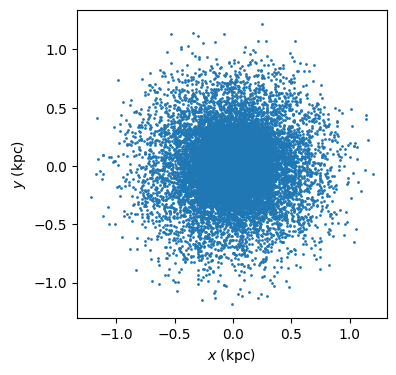

In [10]:
print("Phase-space coordinates shape:", phase_space_coords.shape)

#Plot a x-y scatter plot to visualize the distribution
x = phase_space_coords[:, 0]
y = phase_space_coords[:, 1]
z = phase_space_coords[:, 2]

plt.figure(figsize=(4, 4))
plt.scatter(x, y, s=1)
plt.xlabel(r"$x$ (kpc)")
plt.ylabel(r"$y$ (kpc)")
plt.axis("equal")
plt.show()

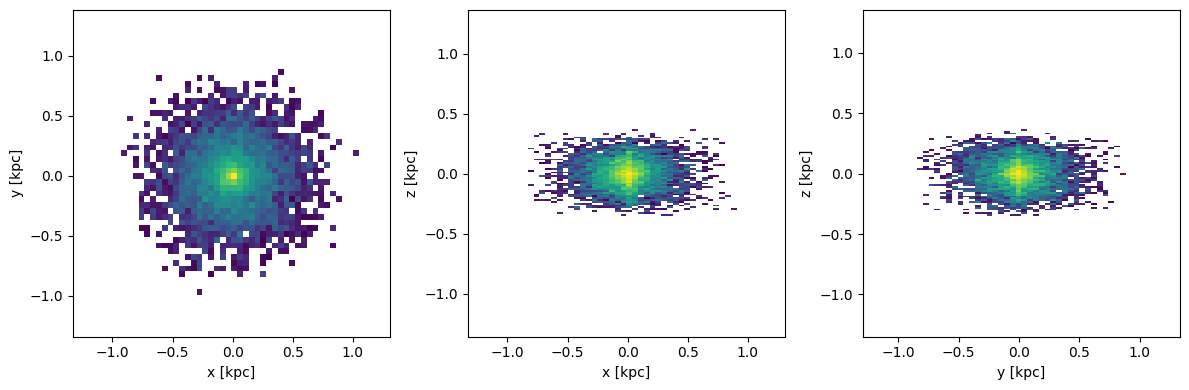

In [11]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.hist2d(x, y, bins=50, cmap="viridis", norm=colors.LogNorm(), cmin=1, weights=soft_weights)
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.axis('equal')
plt.subplot(132)
plt.hist2d(x, z, bins=50, cmap="viridis", norm=colors.LogNorm(), cmin=1, weights=soft_weights)
plt.xlabel('x [kpc]')
plt.ylabel('z [kpc]')
plt.axis('equal')
plt.subplot(133)
plt.hist2d(y, z, bins=50, cmap="viridis", norm=colors.LogNorm(), cmin=1, weights=soft_weights)
plt.xlabel('y [kpc]')
plt.ylabel('z [kpc]')
plt.axis('equal')
plt.tight_layout()
plt.show()

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def compute_density(x, y, z, weights, r_bins, z_bins):
    """
    Compute the density as a function of r and z.

    Parameters:
    -----------
    x, y, z : array-like
        Cartesian coordinates of the particles.
    weights : array-like
        Weights of the particles.
    r_bins : array-like
        Bin edges for the radial coordinate r.
    z_bins : array-like
        Bin edges for the vertical coordinate z.

    Returns:
    --------
    density : 2D array
        Density in each r-z bin.
    """
    #Normalisation factor
    norm_factor = np.sum(weights)
    weights = weights / norm_factor
    # Compute radial distance r
    r = np.sqrt(x**2 + y**2)

    # Digitize r and z into bins
    r_idx = np.digitize(r, r_bins) - 1
    z_idx = np.digitize(z, z_bins) - 1

    # Initialize density array
    density = np.zeros((len(r_bins) - 1, len(z_bins) - 1))

    # Compute the volume of each bin
    r_bin_widths = np.diff(r_bins)
    z_bin_widths = np.diff(z_bins)
    bin_volumes = np.outer(r_bin_widths, z_bin_widths) * 2 * np.pi * r_bins[:-1]

    # Accumulate weights in each bin
    for i in range(len(r)):
        if 0 <= r_idx[i] < len(r_bins) - 1 and 0 <= z_idx[i] < len(z_bins) - 1:
            density[r_idx[i], z_idx[i]] += weights[i]

    # Normalize by bin volumes to get density
    density /= bin_volumes

    return density

In [13]:
import jax
import jax.numpy as jnp

def compute_density_jax(x, y, z, weights, r_bins, z_bins):
    # 1. Compute radial distance r
    r = jnp.sqrt(x**2 + y**2)

    # 2. Use histogram2d to accumulate weights efficiently
    # This replaces the entire fori_loop and digitize logic
    counts, _, _ = jnp.histogram2d(
        r, z, 
        bins=[r_bins, z_bins], 
        weights=weights
    )

    # 3. Compute the volume of each bin
    # Use midpoint r for volume calculation to be more accurate
    r_mid = (r_bins[:-1] + r_bins[1:]) / 2
    r_widths = jnp.diff(r_bins)
    z_widths = jnp.diff(z_bins)
    
    # Calculate volume of cylindrical shell: V = 2 * pi * r * dr * dz
    bin_volumes = 2 * jnp.pi * jnp.outer(r_mid * r_widths, z_widths)

    # 4. Normalize
    density = counts / bin_volumes
    
    return density

In [14]:
density = compute_density_jax(x, y, z, soft_weights, r_bins=np.linspace(0, 2, 10), z_bins=np.linspace(-1, 1, 10))

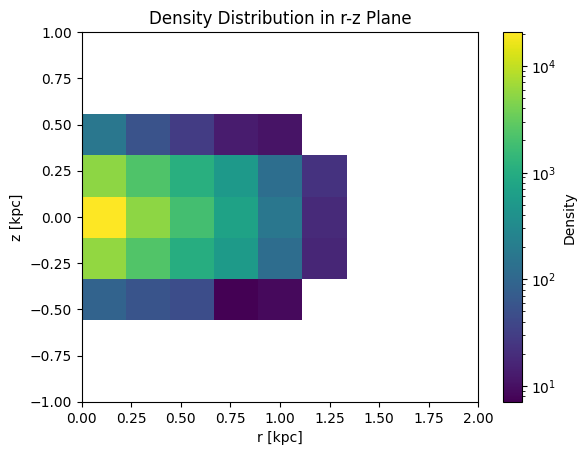

In [15]:
plt.imshow(density.T, origin='lower', aspect='auto',
           extent=[0, 2, -1, 1], cmap='viridis', norm=colors.LogNorm())
plt.colorbar(label='Density')
plt.xlabel('r [kpc]')
plt.ylabel('z [kpc]')
plt.title('Density Distribution in r-z Plane')
plt.show()

In [16]:
import jax
import jax.numpy as jnp

def compute_laplacian_on_grid(potential, theta, r_bins, z_bins):
    """
    Computes nabla^2 Phi (Laplacian) on the centers of the R-Z bins.
    """
    
    # 1. Define the Laplacian for a SINGLE point (x, y, z)
    def potential_wrapper(x, y, z):
        return potential(x, y, z, *theta)

    def laplacian_fn(x, y, z):
        # jax.hessian returns a 3x3 matrix of second derivatives
        # argnums=(0, 1, 2) makes it return a nested tuple structure relative to x,y,z
        # However, it's easier to treat input as a vector for Hessian logic,
        # but since our function takes scalars, we can just sum unmixed 2nd derivatives.
        
        # Method A: Direct curvature calculation (faster/simpler than full Hessian)
        # We use simple nested grad or specific derivative operators
        d2dx2 = jax.grad(lambda x_: jax.grad(potential_wrapper, argnums=0)(x_, y, z))(x)
        d2dy2 = jax.grad(lambda y_: jax.grad(potential_wrapper, argnums=1)(x, y_, z))(y)
        d2dz2 = jax.grad(lambda z_: jax.grad(potential_wrapper, argnums=2)(x, y, z_))(z)
        
        return d2dx2 + d2dy2 + d2dz2

    # 2. Vectorize the Laplacian function
    # Maps over inputs x, y, z
    laplacian_vmap = jax.vmap(laplacian_fn, in_axes=(0, 0, 0))

    # 3. Setup Grid (Bin Centers)
    r_centers = 0.5 * (r_bins[:-1] + r_bins[1:])
    z_centers = 0.5 * (z_bins[:-1] + z_bins[1:])
    
    # Create Meshgrid (indexing='ij' matches density shape)
    R_grid, Z_grid = jnp.meshgrid(r_centers, z_centers, indexing='ij')

    # 4. Convert R-Z to Cartesian X-Y-Z
    # We evaluate at y=0, so x=R
    X_flat = R_grid.flatten()
    Y_flat = jnp.zeros_like(X_flat)
    Z_flat = Z_grid.flatten()

    # 5. Compute
    laplacian_flat = laplacian_vmap(X_flat, Y_flat, Z_flat)
    
    # Reshape back to (N_r, N_z)
    laplacian_grid = laplacian_flat.reshape(R_grid.shape)
    
    return laplacian_grid


In [17]:
r_bins = jnp.linspace(0.1, 2, 10) # Avoid 0 if potential has singularity at origin
z_bins = jnp.linspace(-1, 1, 10)

# JIT Compile
#jit_laplacian = jax.jit(compute_laplacian_on_grid)

# Run
#nabla2_Phi = jit_laplacian(r_bins, z_bins, theta)

nabla2_Phi = compute_laplacian_on_grid(Phi, theta, r_bins, z_bins)

print("Laplacian shape:", nabla2_Phi.shape)

Laplacian shape: (9, 9)


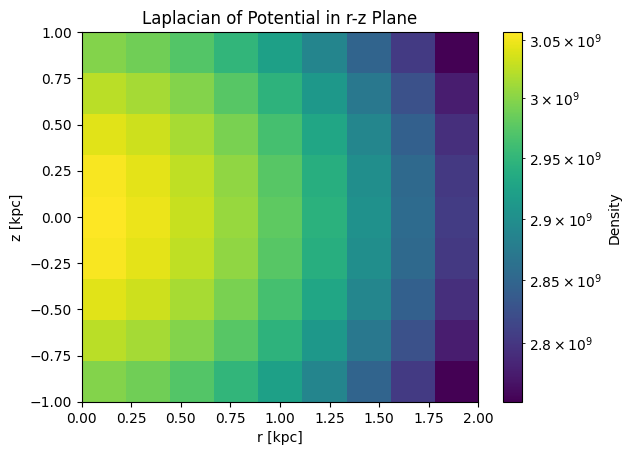

In [18]:
plt.imshow(nabla2_Phi.T, origin='lower', aspect='auto',
           extent=[0, 2, -1, 1], cmap='viridis', norm=colors.LogNorm())
plt.colorbar(label='Density')
plt.xlabel('r [kpc]')
plt.ylabel('z [kpc]')
plt.title('Laplacian of Potential in r-z Plane')
plt.show()

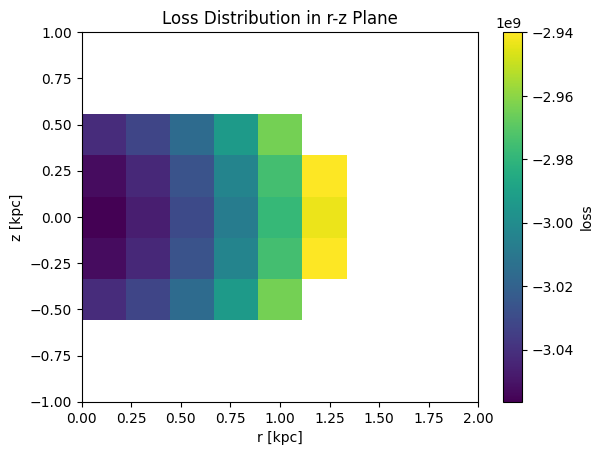

In [19]:
G = 1e-11
lossplane = (4*jnp.pi*G*density - nabla2_Phi)*density/density
#mask = density > 0
#lossplane = lossplane * mask

plt.imshow(lossplane.T, origin='lower', aspect='auto',
           extent=[0, 2, -1, 1], cmap='viridis')#, norm=colors.LogNorm())
plt.colorbar(label='loss')
plt.xlabel('r [kpc]')
plt.ylabel('z [kpc]')
plt.title('Loss Distribution in r-z Plane')
plt.show()

In [20]:
def compute_loss(key, params, Phi_thin, Phi_thick, Phi_spheroid, theta_thin, theta_thick, theta_spheroid, theta_halo, n_candidates, envelope_max):
    candidates, samples, soft_weights = sampling.sample_df_potential(key, params, Phi_thin, Phi_thick, Phi_spheroid, theta_thin, theta_thick, theta_spheroid, n_candidates, envelope_max, tau=0.01)
    theta = (theta_thin, theta_thick, theta_spheroid, theta_halo)
    Phi = combined_potential
    phase_space_coords = actions_to_phase_space.map_actions_to_phase_space(samples, params, key, Phi, theta)
    x = phase_space_coords[:, 0]
    y = phase_space_coords[:, 1]
    z = phase_space_coords[:, 2]
    density = compute_density_jax(x, y, z, soft_weights, r_bins=np.linspace(0, 2, 10), z_bins=np.linspace(-1, 1, 10))
    nabla2_Phi = compute_laplacian_on_grid(Phi, theta, r_bins=np.linspace(0, 2, 10), z_bins=np.linspace(-1, 1, 10))
    lossplane = (4*jnp.pi*G*density - nabla2_Phi)*density/density

    return lossplane
    

In [21]:
lossplane2 = compute_loss(key, params, Phi_thin, Phi_thick, Phi_spheroid, theta_thin, theta_thick, theta_spheroid, theta_halo, n_candidates, envelope_max)

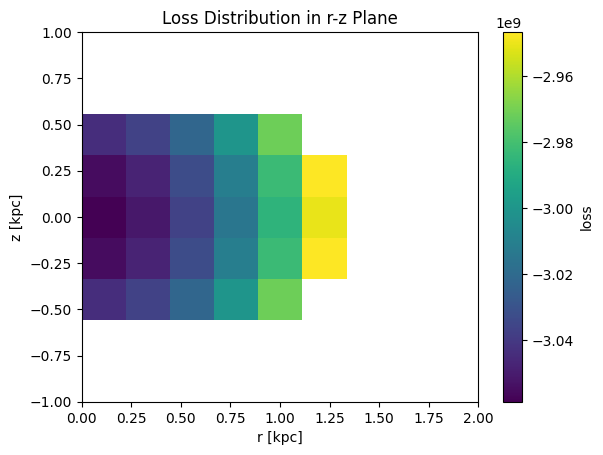

In [22]:
plt.imshow(lossplane2.T, origin='lower', aspect='auto',
           extent=[0, 2, -1, 1], cmap='viridis')#, norm=colors.LogNorm())
plt.colorbar(label='loss')
plt.xlabel('r [kpc]')
plt.ylabel('z [kpc]')
plt.title('Loss Distribution in r-z Plane')
plt.show()